# Description

It runs a Spectral Clustering (SC) algorithm on the similarity matrix generated by the correlation method specified below (under `Settings`). It saves the set of clustering solutions (called "ensemble") into a pandas dataframe.

# Modules loading

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from clustermatch import conf
from clustermatch.utils import simplify_string
from clustermatch.clustering import generate_ensemble

# Settings

In [2]:
CORRELATION_METHOD_NAME = "clustermatch_k2"

In [3]:
GENE_SELECTION_STRATEGY = "var_pc_log2"

In [4]:
# Tissues with largest sample size from GTEx (see nbs/05_preprocessing/00-gtex_v8-split_by_tissue.ipynb)
TISSUES = [
    "Muscle - Skeletal",
    "Whole Blood",
    "Skin - Sun Exposed (Lower leg)",
    "Adipose - Subcutaneous",
    "Artery - Tibial",
]

In [5]:
# range of k values that will be used by the clustering algorithm
K_RANGE = [2] + np.arange(5, 100 + 1, 5).tolist() + [125, 150, 175, 200]

In [6]:
# number of times the algorithm will be run for each configuration; it will pick the "best" partition among these, according
# to some internal criteria (see the algorithm's documentation for more information on this parameter, which is `n_init`).
N_INIT = 50

In [7]:
INITIAL_RANDOM_STATE = 12345

In [8]:
def process_similarity_matrix(similarity_matrix):
    """
    It process the similarity matrix to perform any needed adjustment before performing cluster analysis on it.
    """
    # for clustermatch, negative values are meaningless, so we replace them by zero
    similarity_matrix[similarity_matrix < 0.0] = 0.0
    return similarity_matrix

In [9]:
def get_distance_matrix(similarity_matrix):
    """
    It converts the processed similarity matrix into a distance matrix. This is needed to compute some clustering quality measures.
    """
    # the clustermatch coefficient goes from 0 (sometime also negative values that are mean the same as zero) to 1.0
    # the distance is jst 1 minor the coefficient
    return 1.0 - similarity_matrix

# Paths

In [10]:
INPUT_DIR = conf.GTEX["SIMILARITY_MATRICES_DIR"]
display(INPUT_DIR)
assert INPUT_DIR.exists()

PosixPath('/opt/data/results/gtex_v8/similarity_matrices')

In [11]:
OUTPUT_DIR = conf.GTEX["CLUSTERING_DIR"]
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
display(INPUT_DIR)

PosixPath('/opt/data/results/gtex_v8/similarity_matrices')

# Setup clustering options

In [12]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_RANGE"] = K_RANGE
CLUSTERING_OPTIONS["KMEANS_N_INIT"] = N_INIT

display(CLUSTERING_OPTIONS)

{'K_RANGE': [2,
  5,
  10,
  15,
  20,
  25,
  30,
  35,
  40,
  45,
  50,
  55,
  60,
  65,
  70,
  75,
  80,
  85,
  90,
  95,
  100,
  125,
  150,
  175,
  200],
 'KMEANS_N_INIT': 50}

# Get data files

In [13]:
# get input data files according to Settings
input_files = list(
    INPUT_DIR.glob(f"*-{GENE_SELECTION_STRATEGY}-{CORRELATION_METHOD_NAME}.pkl")
)
display(len(input_files))
display(input_files[:5])

5

[PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_muscle_skeletal-var_pc_log2-clustermatch_k2.pkl'),
 PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_skin_sun_exposed_lower_leg-var_pc_log2-clustermatch_k2.pkl'),
 PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_whole_blood-var_pc_log2-clustermatch_k2.pkl'),
 PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_artery_tibial-var_pc_log2-clustermatch_k2.pkl'),
 PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_adipose_subcutaneous-var_pc_log2-clustermatch_k2.pkl')]

## Filter files by selected tissues

In [14]:
# convert tissue name to internal, simplified representation
tissue_names_map = {simplify_string(t.lower()): t for t in TISSUES}
display(tissue_names_map)

{'muscle_skeletal': 'Muscle - Skeletal',
 'whole_blood': 'Whole Blood',
 'skin_sun_exposed_lower_leg': 'Skin - Sun Exposed (Lower leg)',
 'adipose_subcutaneous': 'Adipose - Subcutaneous',
 'artery_tibial': 'Artery - Tibial'}

In [15]:
# filter by selected tissues
input_files = sorted(
    [
        f
        for f in input_files
        if any(f"gtex_v8_data_{tn}-" in f.name for tn in tissue_names_map)
    ]
)
display(len(input_files))
display(input_files)

# make sure we got the right number
assert len(input_files) == len(TISSUES), len(TISSUES)

5

[PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_adipose_subcutaneous-var_pc_log2-clustermatch_k2.pkl'),
 PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_artery_tibial-var_pc_log2-clustermatch_k2.pkl'),
 PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_muscle_skeletal-var_pc_log2-clustermatch_k2.pkl'),
 PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_skin_sun_exposed_lower_leg-var_pc_log2-clustermatch_k2.pkl'),
 PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_whole_blood-var_pc_log2-clustermatch_k2.pkl')]

## Show the content of one similarity matrix

In [16]:
sim_matrix = pd.read_pickle(input_files[0])

In [17]:
sim_matrix.shape

(5000, 5000)

In [18]:
sim_matrix.head()

gene_ens_id,ENSG00000129824.15,ENSG00000149968.11,ENSG00000134184.12,ENSG00000224114.1,ENSG00000173432.10,ENSG00000067048.16,ENSG00000229807.10,ENSG00000012817.15,ENSG00000134339.8,ENSG00000175084.11,...,ENSG00000197467.13,ENSG00000279807.1,ENSG00000107742.12,ENSG00000176454.13,ENSG00000212206.1,ENSG00000104611.11,ENSG00000181800.5,ENSG00000171049.8,ENSG00000257671.1,ENSG00000180448.10
gene_ens_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000129824.15,1.000000,0.092378,-0.001128,-0.000690,0.105775,0.308716,0.216031,0.339720,0.117969,0.037587,...,0.000677,-0.000089,0.011996,0.045078,0.003958,0.000968,0.003101,0.001606,-0.001511,0.002317
ENSG00000149968.11,0.092378,1.000000,0.000403,0.001278,-0.000508,0.036402,0.063560,0.062029,0.004887,0.005379,...,0.041250,0.023606,0.002317,0.014949,0.023606,-0.001237,0.019925,0.012707,0.030752,-0.000508
ENSG00000134184.12,-0.001128,0.000403,1.000000,-0.000508,-0.001328,-0.001000,-0.001328,-0.001456,-0.001128,-0.000089,...,0.006418,-0.001000,-0.001401,0.003520,-0.000089,0.000677,0.001606,0.004887,-0.001511,-0.001492
ENSG00000224114.1,-0.000690,0.001278,-0.000508,1.000000,-0.000690,-0.001000,-0.001511,-0.001237,-0.001000,-0.000854,...,0.003101,-0.000308,-0.001237,-0.001237,-0.000854,-0.001401,-0.001237,0.001278,-0.001237,-0.000854
ENSG00000173432.10,0.105775,-0.000508,-0.001328,-0.000690,1.000000,0.107761,0.065110,0.105775,0.815978,0.046390,...,0.046390,-0.001511,0.040011,0.126462,-0.001492,0.015732,0.004413,0.024573,-0.001456,0.001278


# Clustering

## Generate clusterers

A "clusterer" is an instance of one clustering algorithm with a specified set of parameters. For instance, KMeans with `n_clusters=2` and `random_state=189`.

In [19]:
clusterers = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    clus = SpectralClustering(
        eigen_solver="arpack",
        n_clusters=k,
        n_init=CLUSTERING_OPTIONS["KMEANS_N_INIT"],
        affinity="precomputed",
        random_state=random_state,
    )

    method_name = type(clus).__name__
    clusterers[f"{method_name} #{idx}"] = clus

    random_state = random_state + 1
    idx = idx + 1

In [20]:
display(len(clusterers))

25

In [21]:
_iter = iter(clusterers.items())
display(next(_iter))
display(next(_iter))

('SpectralClustering #0',
 SpectralClustering(affinity='precomputed', eigen_solver='arpack', n_clusters=2,
                    n_init=50, random_state=12345))

('SpectralClustering #1',
 SpectralClustering(affinity='precomputed', eigen_solver='arpack', n_clusters=5,
                    n_init=50, random_state=12346))

In [22]:
clustering_method_name = method_name
display(clustering_method_name)

'SpectralClustering'

## Generate ensemble

In [23]:
output_files = []
pbar = tqdm(input_files, ncols=100)

for tissue_data_file in pbar:
    pbar.set_description(tissue_data_file.stem)

    # read similarity matrix for this tissue
    sim_matrix = pd.read_pickle(tissue_data_file)
    sim_matrix = process_similarity_matrix(sim_matrix)

    # generate ensemble
    ensemble = generate_ensemble(
        sim_matrix,
        clusterers,
        tqdm_args={"leave": False, "ncols": 100},
    )

    # perform some checks on the generate ensemble
    # there should be a single k among ensemble partitions
    _tmp = ensemble["n_clusters"].value_counts().unique()
    assert _tmp.shape[0] == 1
    assert _tmp[0] == 1

    assert not ensemble["n_clusters"].isna().any()

    assert ensemble.shape[0] == len(clusterers)

    # no partition has negative labels or nan
    assert not np.any(
        [np.isnan(part["partition"]).any() for idx, part in ensemble.iterrows()]
    )
    assert not np.any(
        [(part["partition"] < 0).any() for idx, part in ensemble.iterrows()]
    )

    # all partitions must have the size of the data
    assert np.all(
        [
            part["partition"].shape[0] == sim_matrix.shape[0]
            for idx, part in ensemble.iterrows()
        ]
    )

    # the number of unique labels in the partition must match the k specified
    _real_k_values = ensemble["partition"].apply(lambda x: np.unique(x).shape[0])
    assert np.all(ensemble["n_clusters"].values == _real_k_values.values)

    # add clustering quality measures
    dist_matrix = get_distance_matrix(sim_matrix)

    ensemble = ensemble.assign(
        si_score=ensemble["partition"].apply(
            lambda x: silhouette_score(dist_matrix, x, metric="precomputed")
        ),
    )

    # save
    output_filename = f"{tissue_data_file.stem}-{clustering_method_name}.pkl"
    output_filepath = OUTPUT_DIR / output_filename
    output_files.append(output_filepath)

    ensemble.to_pickle(path=output_filepath)

gtex_v8_data_adipose_subcutaneous-var_pc_log2-clustermatch_k2:   0%|          | 0/5 [00:00<?, ?it/s]
100%|███████████████████████████████████████████████████████████████| 25/25 [10:12<00:00, 69.17s/it]
gtex_v8_data_artery_tibial-var_pc_log2-clustermatch_k2:  20%|█▌      | 1/5 [10:16<41:07, 616.90s/it]
100%|███████████████████████████████████████████████████████████████| 25/25 [10:30<00:00, 70.46s/it]
gtex_v8_data_muscle_skeletal-var_pc_log2-clustermatch_k2:  40%|██▍   | 2/5 [20:51<31:22, 627.40s/it]
100%|███████████████████████████████████████████████████████████████| 25/25 [11:27<00:00, 79.27s/it]
gtex_v8_data_skin_sun_exposed_lower_leg-var_pc_log2-clustermatch_k2:  60%|▌| 3/5 [32:22<21:53, 656.5
100%|███████████████████████████████████████████████████████████████| 25/25 [10:20<00:00, 69.74s/it]
gtex_v8_data_whole_blood-var_pc_log2-clustermatch_k2:  80%|████████  | 4/5 [42:47<10:43, 643.96s/it]
100%|███████████████████████████████████████████████████████████████| 25/25 [10:57<00:00, 7

# Plot cluster quality measures

In [24]:
def get_tissue_name(filename):
    tissue_simplified_name = filename.split("gtex_v8_data_")[1].split(
        f"-{GENE_SELECTION_STRATEGY}"
    )[0]
    return tissue_names_map[tissue_simplified_name]

In [25]:
# combine all partitions across tissues
ensembles = []

for f in output_files:
    tissue_name = get_tissue_name(f.name)

    ensemble = pd.read_pickle(f)[["n_clusters", "si_score"]]
    ensemble["tissue"] = tissue_name

    ensembles.append(ensemble)

ensembles = pd.concat(ensembles, ignore_index=True)

In [26]:
ensembles.head()

,n_clusters,si_score,tissue
0,2,0.028595,Adipose - Subcutaneous
1,5,0.030045,Adipose - Subcutaneous
2,10,0.030650,Adipose - Subcutaneous
3,15,0.032396,Adipose - Subcutaneous
4,20,0.033087,Adipose - Subcutaneous


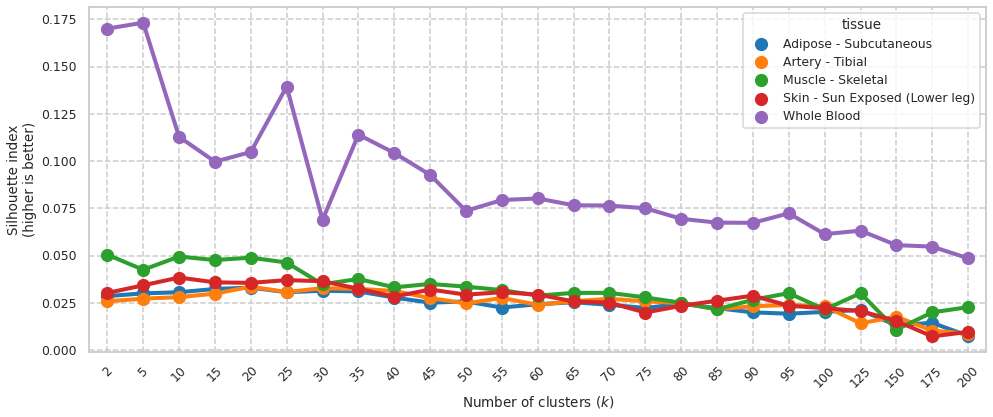

In [27]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))

    ax = sns.pointplot(data=ensembles, x="n_clusters", y="si_score", hue="tissue")

    ax.set_ylabel("Silhouette index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()
    display(fig)
    plt.close(fig)